C:\Users\prati\AppData\Local\Temp\ipykernel_24508\3029095587.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_value_customers['churn'] = (
C:\Users\prati\AppData\Local\Temp\ipykernel_24508\3029095587.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  high_value_customers_clean

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92      8226
           1       0.37      0.78      0.50       778

    accuracy                           0.86      9004
   macro avg       0.67      0.83      0.71      9004
weighted avg       0.92      0.86      0.88      9004

Confusion Matrix:
 [[7172 1054]
 [ 172  606]]
Logistic Regression ROC-AUC Score: 0.8882405902158621


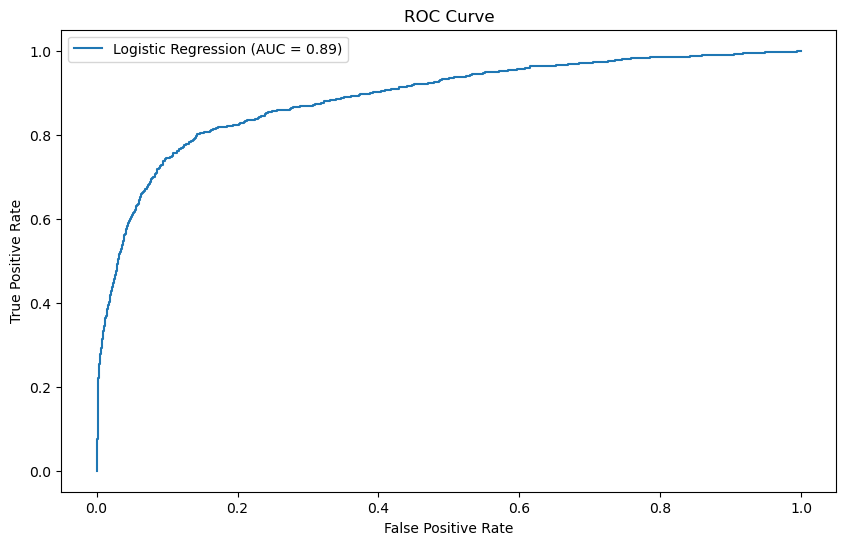

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      8226
           1       0.60      0.67      0.64       778

    accuracy                           0.93      9004
   macro avg       0.79      0.82      0.80      9004
weighted avg       0.94      0.93      0.94      9004

Confusion Matrix:
 [[7880  346]
 [ 253  525]]
Random Forest ROC-AUC Score: 0.9234114573079152


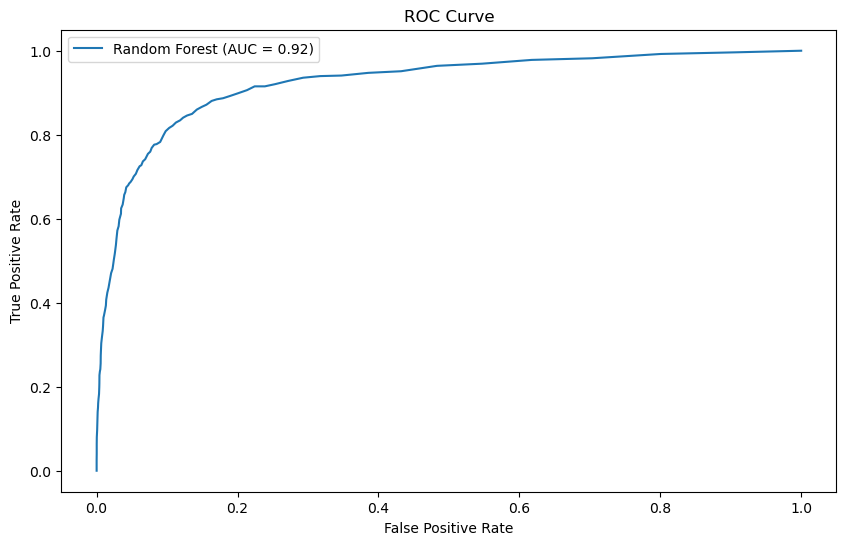

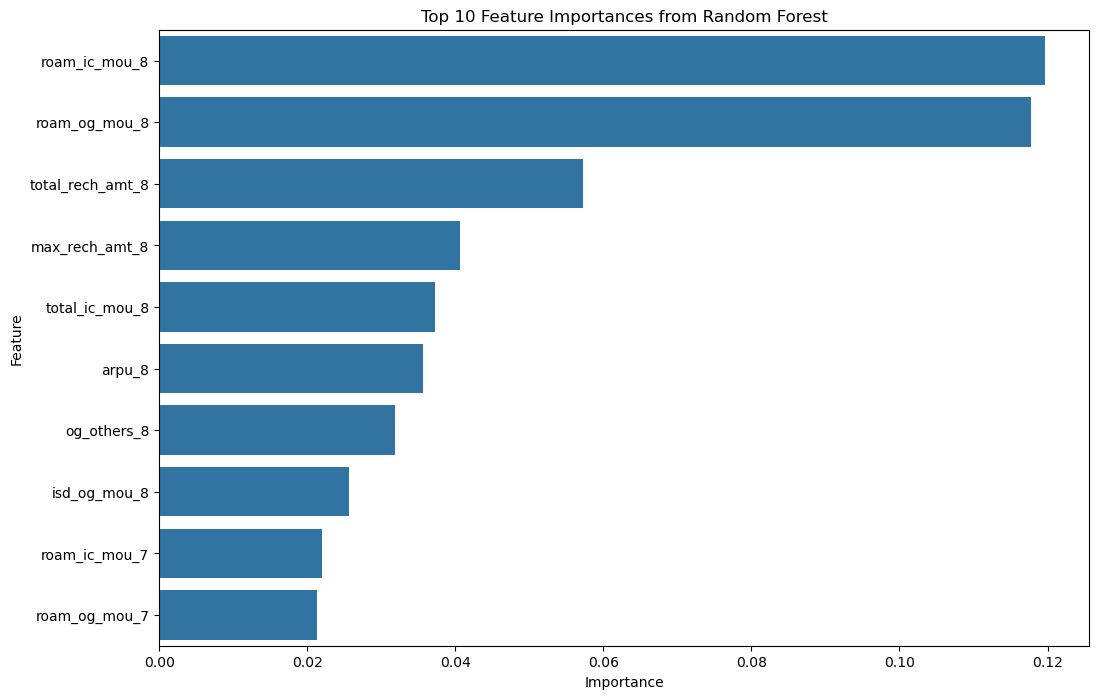


Model Comparison:

Logistic Regression ROC-AUC Score: 0.89
Random Forest ROC-AUC Score: 0.92
The Random Forest model performs better based on ROC-AUC score.
Chosen Model: Random Forest


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

# Load the dataset
# Preprocess data (convert columns to appropriate formats, handle missing values, etc.)
file_path = r'C:\Users\prati\Desktop\project\telecom_churn_data.csv'
telecom_data = pd.read_csv(file_path)

# Calculate the average recharge amount for the first two months
telecom_data['avg_rech_amt_good_phase'] = (
    telecom_data['total_rech_amt_6'] + telecom_data['total_rech_amt_7']
) / 2

# Determine the 70th percentile threshold for average recharge amount
recharge_threshold = telecom_data['avg_rech_amt_good_phase'].quantile(0.7)

# Filter high-value customers
high_value_customers = telecom_data[telecom_data['avg_rech_amt_good_phase'] >= recharge_threshold]

# Tag churners based on churn phase activity in the fourth month
high_value_customers['churn'] = (
    (high_value_customers['total_ic_mou_9'] == 0) &
    (high_value_customers['total_og_mou_9'] == 0) &
    (high_value_customers['vol_2g_mb_9'] == 0) &
    (high_value_customers['vol_3g_mb_9'] == 0)
).astype(int)

# Drop churn phase columns (attributes with '_9' suffix)
columns_to_drop = [col for col in high_value_customers.columns if '_9' in col]
high_value_customers_cleaned = high_value_customers.drop(columns=columns_to_drop, axis=1)

# Handle missing values
# Drop columns with more than 50% missing values
threshold = 0.5
missing_percentages = high_value_customers_cleaned.isnull().sum() / len(high_value_customers_cleaned)
columns_to_drop_missing = missing_percentages[missing_percentages > threshold].index
high_value_customers_cleaned = high_value_customers_cleaned.drop(columns=columns_to_drop_missing, axis=1)

# Impute remaining missing values with mean or mode
for col in high_value_customers_cleaned.columns:
    if high_value_customers_cleaned[col].isnull().sum() > 0:
        if high_value_customers_cleaned[col].dtype == 'object':
            high_value_customers_cleaned[col].fillna(
                high_value_customers_cleaned[col].mode()[0], inplace=True
            )
        else:
            high_value_customers_cleaned[col].fillna(
                high_value_customers_cleaned[col].mean(), inplace=True
            )

# Convert columns to appropriate data types
for col in high_value_customers_cleaned.columns:
    if high_value_customers_cleaned[col].dtype == 'object':
        try:
            high_value_customers_cleaned[col] = pd.to_datetime(high_value_customers_cleaned[col], errors='coerce')
        except Exception:
            pass

# Remove datetime columns
datetime_cols = high_value_customers_cleaned.select_dtypes(include=['datetime64']).columns
high_value_customers_cleaned = high_value_customers_cleaned.drop(columns=datetime_cols)

# Handle non-numeric columns by encoding or dropping
high_value_customers_cleaned = pd.get_dummies(high_value_customers_cleaned, drop_first=True)

# Split the data into features and target
X = high_value_customers_cleaned.drop(columns=['churn'])
y = high_value_customers_cleaned['churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Train a model, tune model hyperparameters, etc.
# Logistic Regression Model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_resampled, y_train_resampled)

# Predictions and evaluation
y_pred_log_reg = log_reg.predict(X_test)
y_pred_prob_log_reg = log_reg.predict_proba(X_test)[:, 1]

print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log_reg))

# ROC-AUC score and curve
roc_auc = roc_auc_score(y_test, y_pred_prob_log_reg)
print("Logistic Regression ROC-AUC Score:", roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_log_reg)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train_resampled, y_train_resampled)

# Predictions and evaluation
y_pred_rf = rf_clf.predict(X_test)
y_pred_prob_rf = rf_clf.predict_proba(X_test)[:, 1]

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# ROC-AUC score and curve
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)
print("Random Forest ROC-AUC Score:", roc_auc_rf)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Feature importance from Random Forest
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top features visually
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importances.head(10), x='Importance', y='Feature')
plt.title('Top 10 Feature Importances from Random Forest')
plt.show()

# Save cleaned data for modeling
cleaned_file_path = r'C:\Users\prati\Desktop\project\high_value_customers_cleaned.csv'
high_value_customers_cleaned.to_csv(cleaned_file_path, index=False)

# Evaluate the models using appropriate evaluation metrics.
# Compare models and choose the best
print("\nModel Comparison:\n")
print(f"Logistic Regression ROC-AUC Score: {roc_auc:.2f}")
print(f"Random Forest ROC-AUC Score: {roc_auc_rf:.2f}")

if roc_auc_rf > roc_auc:
    print("The Random Forest model performs better based on ROC-AUC score.")
    chosen_model = "Random Forest"
else:
    print("The Logistic Regression model performs better based on ROC-AUC score.")
    chosen_model = "Logistic Regression"

# Finally, choose a model based on an evaluation metric with proper justification.
print(f"Chosen Model: {chosen_model}")
